In [23]:
import pandas as pd
df = pd.read_csv('clean_train.csv')
df.head()

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,0.730463,2.055642,5.831328,19.212182,0.730463,0.730463,1.540963,0.0,2.440268,1.820334,...,0,0,1,0,0,0,0,1,0,208500
1,1.194318,0.000000,6.221214,19.712205,0.730463,0.730463,1.540963,0.0,2.259674,2.440268,...,0,0,1,0,0,0,0,1,0,181500
2,1.540963,2.055642,5.914940,20.347241,0.730463,0.730463,0.000000,0.0,2.440268,1.820334,...,0,0,1,0,0,0,0,1,0,223500
3,1.820334,2.259674,5.684507,19.691553,0.730463,0.730463,0.000000,0.0,2.440268,1.820334,...,0,0,1,1,0,0,0,0,0,140000
4,2.055642,2.055642,6.314735,21.325160,0.730463,0.730463,0.000000,0.0,2.602594,1.820334,...,0,0,1,0,0,0,0,1,0,250000


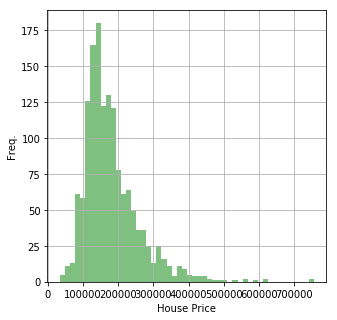

In [24]:
from matplotlib import pyplot as plt

df['SalePrice'].hist(bins=50, facecolor='green', alpha=0.5)
plt.xlabel('House Price')
plt.ylabel('Freq.')
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.show()

In [25]:
df = df.drop(df[df['SalePrice'] > 450000].index)
df = df.drop(columns=['Id'])
df = df.drop(df[df['SalePrice'] <  50000].index)

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
from sklearn.decomposition import PCA
import numpy as np

y = np.log(df['SalePrice'].values)
x = df.drop(columns=['SalePrice']).values

data_dmatrix = xgb.DMatrix(data=x,label=y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [27]:
scaler = RobustScaler()
scaler.fit(x_train)
x_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

pca = PCA(n_components=0.995)

pca.fit(x_scaled)
x_pca = pca.transform(x_scaled)
x_test_pca = pca.transform(x_test_scaled)

# x_train = x_pca
# x_test = x_test_pca

x_train = x_scaled
x_test = x_test_scaled

In [28]:
# Here we make functions in order to evaluate many different classification models

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import numpy as np

def get_houses_eval_metric(y_actual, y_pred):
    total = 0
    for y_a, y_p in zip(y_actual, y_pred):
        total += (np.log(y_a) - np.log(y_p))**2
    return (total/len(y_actual))**(1/2)

# Print out machine learning model metrics
def evaluation(y_actual, y_pred):
    f = lambda x: np.exp(x)
    y_actual = f(y_actual)
    y_pred = f(y_pred)
    r2 = r2_score(y_actual, y_pred)
    mse = mean_squared_error(y_actual, y_pred)
    rmse = mse**(1/2)
    houses_metric = get_houses_eval_metric(y_actual, y_pred)
    print('R2          : ', round(r2, 4))
    print('RMSE        : ', round(rmse, 2))
    print('HOUSE METRIC: ', round(houses_metric, 4))
    return [r2, mse, rmse, houses_metric]
      
def try_regressor(regressor, name):
    best_mse = np.Inf
    for _ in range(1):
        # Specify that these are global variables
        global x_train, y_train
        global x_test, y_test
        regressor.fit(x_train, y_train)
        if mean_squared_error(y_test, regressor.predict(x_test)) < best_mse:
            print('Evaluation for', name, '\n')
            # Evaluate the test set
            metrics = evaluation(y_test, regressor.predict(x_test))
            best_mse = mean_squared_error(y_test, regressor.predict(x_test))
    return (metrics + [name])

# Make a list to store model evaluation metrics
regressor_results = list()

In [29]:
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor

gb_regr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state = 5)

regressor_results.append(try_regressor(gb_regr, "Gradient Boosting"))

Evaluation for Gradient Boosting 

R2          :  0.9188
RMSE        :  18195.58
HOUSE METRIC:  0.0958


In [30]:
gb2_regr = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=12000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

regressor_results.append(try_regressor(gb2_regr, "Gradient Boosting 2"))

Evaluation for Gradient Boosting 2 

R2          :  0.9127
RMSE        :  18865.24
HOUSE METRIC:  0.0961


In [31]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Lasso

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005))

regressor_results.append(try_regressor(lasso, "Lasso"))

Evaluation for Lasso 

R2          :  0.9264
RMSE        :  17324.37
HOUSE METRIC:  0.0969


In [32]:
from sklearn.linear_model import ElasticNet

elastic = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, max_iter=10000))

regressor_results.append(try_regressor(elastic, "Elastic Net"))

Evaluation for Elastic Net 

R2          :  0.9262
RMSE        :  17348.49
HOUSE METRIC:  0.097


In [33]:
from sklearn.neural_network import MLPRegressor

nn = MLPRegressor(max_iter=500, hidden_layer_sizes=(200,5), learning_rate='adaptive', solver='lbfgs')

regressor_results.append(try_regressor(nn, "Neural Network"))

Evaluation for Neural Network 

R2          :  0.7208
RMSE        :  33735.23
HOUSE METRIC:  0.1965


In [34]:
xg_regr = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

regressor_results.append(try_regressor(xg_regr, "XGBoost"))

Evaluation for XGBoost 

R2          :  0.9181
RMSE        :  18272.59
HOUSE METRIC:  0.0976


In [35]:
y_pred = ( 0.4 * gb_regr.predict(x_test) 
          + 0.1 * gb2_regr.predict(x_test)
          + 0.15 * lasso.predict(x_test)
          + 0.15 * elastic.predict(x_test)
          + 0.2 * xg_regr.predict(x_test)
         )
y_actual = y_test
f = lambda x: np.exp(x)
y_actual = f(y_actual)
y_pred = f(y_pred)
r2 = r2_score(y_actual, y_pred)
mse = mean_squared_error(y_actual, y_pred)
rmse = mse**(1/2)
houses_metric = get_houses_eval_metric(y_actual, y_pred)

houses_metric

0.09075726953326037

In [36]:
df_test = pd.read_csv('clean_test.csv')

In [37]:
df_test.head()

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,13.224069,0.000000,6.221214,20.479373,0.730463,0.730463,1.540963,0.0,2.055642,2.055642,...,0,0,0,1,0,0,0,0,1,0
1,13.226109,0.000000,6.244956,21.327220,0.730463,0.730463,0.000000,0.0,2.259674,2.055642,...,0,0,0,1,0,0,0,0,1,0
2,13.228148,2.055642,6.073289,21.196905,0.730463,0.730463,0.000000,0.0,2.055642,1.820334,...,0,0,0,1,0,0,0,0,1,0
3,13.230186,2.055642,6.172972,19.865444,0.730463,0.730463,0.000000,0.0,2.259674,2.055642,...,0,0,0,1,0,0,0,0,1,0
4,13.232223,3.011340,5.093857,17.257255,0.730463,0.730463,0.000000,0.0,2.602594,1.820334,...,0,0,0,1,0,0,0,0,1,0


In [38]:
df_sub = pd.read_csv('sample_submission.csv')
df_sub.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [39]:
x = df_test.drop(columns=['Id']).values
y_pred = ( 0.4 * gb_regr.predict(x) 
          + 0.1 * gb2_regr.predict(x)
          + 0.15 * lasso.predict(x)
          + 0.15 * elastic.predict(x)
          + 0.2 * xg_regr.predict(x)
         )

df_sub['SalePrice'] = y_pred
df_sub['SalePrice'] = df_sub['SalePrice'].apply(lambda x: np.exp(x))

In [40]:
df_sub.to_csv('submission.csv', index=False)